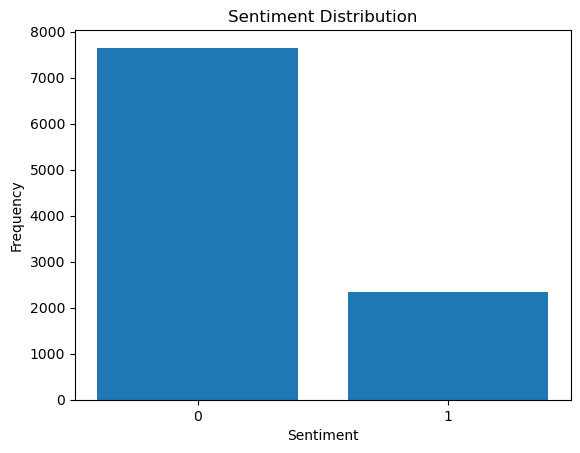

0    7649
1    2351
Name: Sentiment, dtype: int64
Size of dataset: 10000


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv("test.csv")
train_df = pd.read_csv("train.csv")
df.dropna(inplace=True)

sample_size = 10000
train_df = train_df.sample(n=sample_size, random_state=42)
# plot sentiment distribution
val, count = np.unique(train_df['Sentiment'], return_counts=True)
plt.bar(val, count)
plt.xticks(np.arange(0, 2, 1))
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.title('Sentiment Distribution')
plt.show()
print(train_df['Sentiment'].value_counts())


# display size
print('Size of dataset:', train_df.shape[0])

In [2]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')
stop = set(stopwords.words('english'))

def clean(text):
    text = text.lower() # to lowercase
    text = re.sub(r"@\S+", "", text) # remove mentions
    text = re.sub("http[s]?\://\S+","",text) # remove links
    text = re.sub(r"[0-9]", "", text) # remove numbers
    text = re.sub(r"won\'t", "will not", text) #checks for contractions
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    text = re.sub(r"[$&+,:;=?@#|'<>.^*()%!-]", "", text) # remove special characters

    # res = word_tokenize(text)
    # res = [word for word in tokens if not word in stop] # remove stopwords
    # return res
    return text

df['clean_text'] = df['Text'].apply(lambda t: clean(t))
train_df['clean_text'] = train_df['Text'].apply(lambda t: clean(t))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\micha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\micha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Bag of Words - Logistic Regression
               precision    recall  f1-score   support

           0       0.65      0.93      0.77       177
           1       0.89      0.51      0.65       182

    accuracy                           0.72       359
   macro avg       0.77      0.72      0.71       359
weighted avg       0.77      0.72      0.71       359

Bag of Words - SVM
               precision    recall  f1-score   support

           0       0.56      0.99      0.71       177
           1       0.95      0.23      0.37       182

    accuracy                           0.60       359
   macro avg       0.76      0.61      0.54       359
weighted avg       0.76      0.60      0.54       359

Bag of Words - Bayes
               precision    recall  f1-score   support

           0       0.59      0.77      0.67       177
           1       0.69      0.48      0.57       182

    accuracy                           0.63       359
   macro avg       0.64      0.63      0.62       

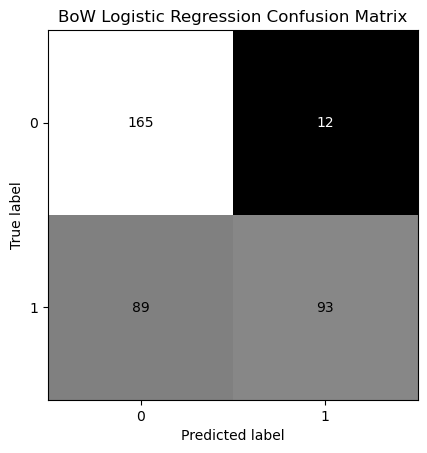

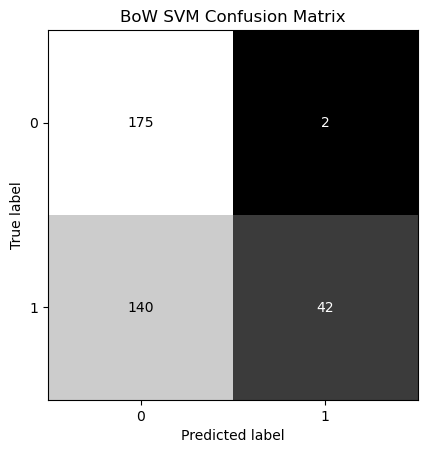

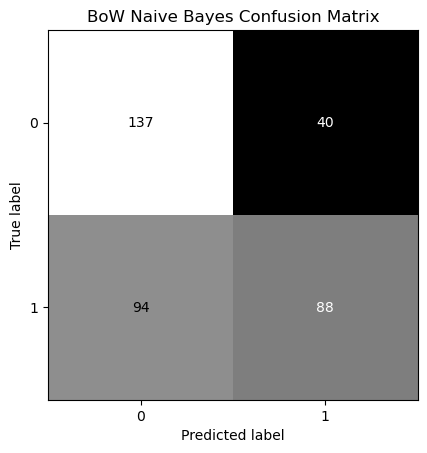

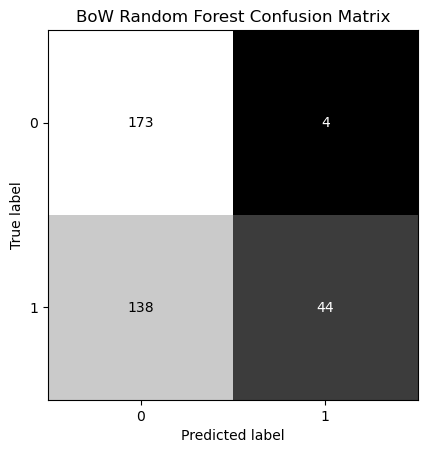

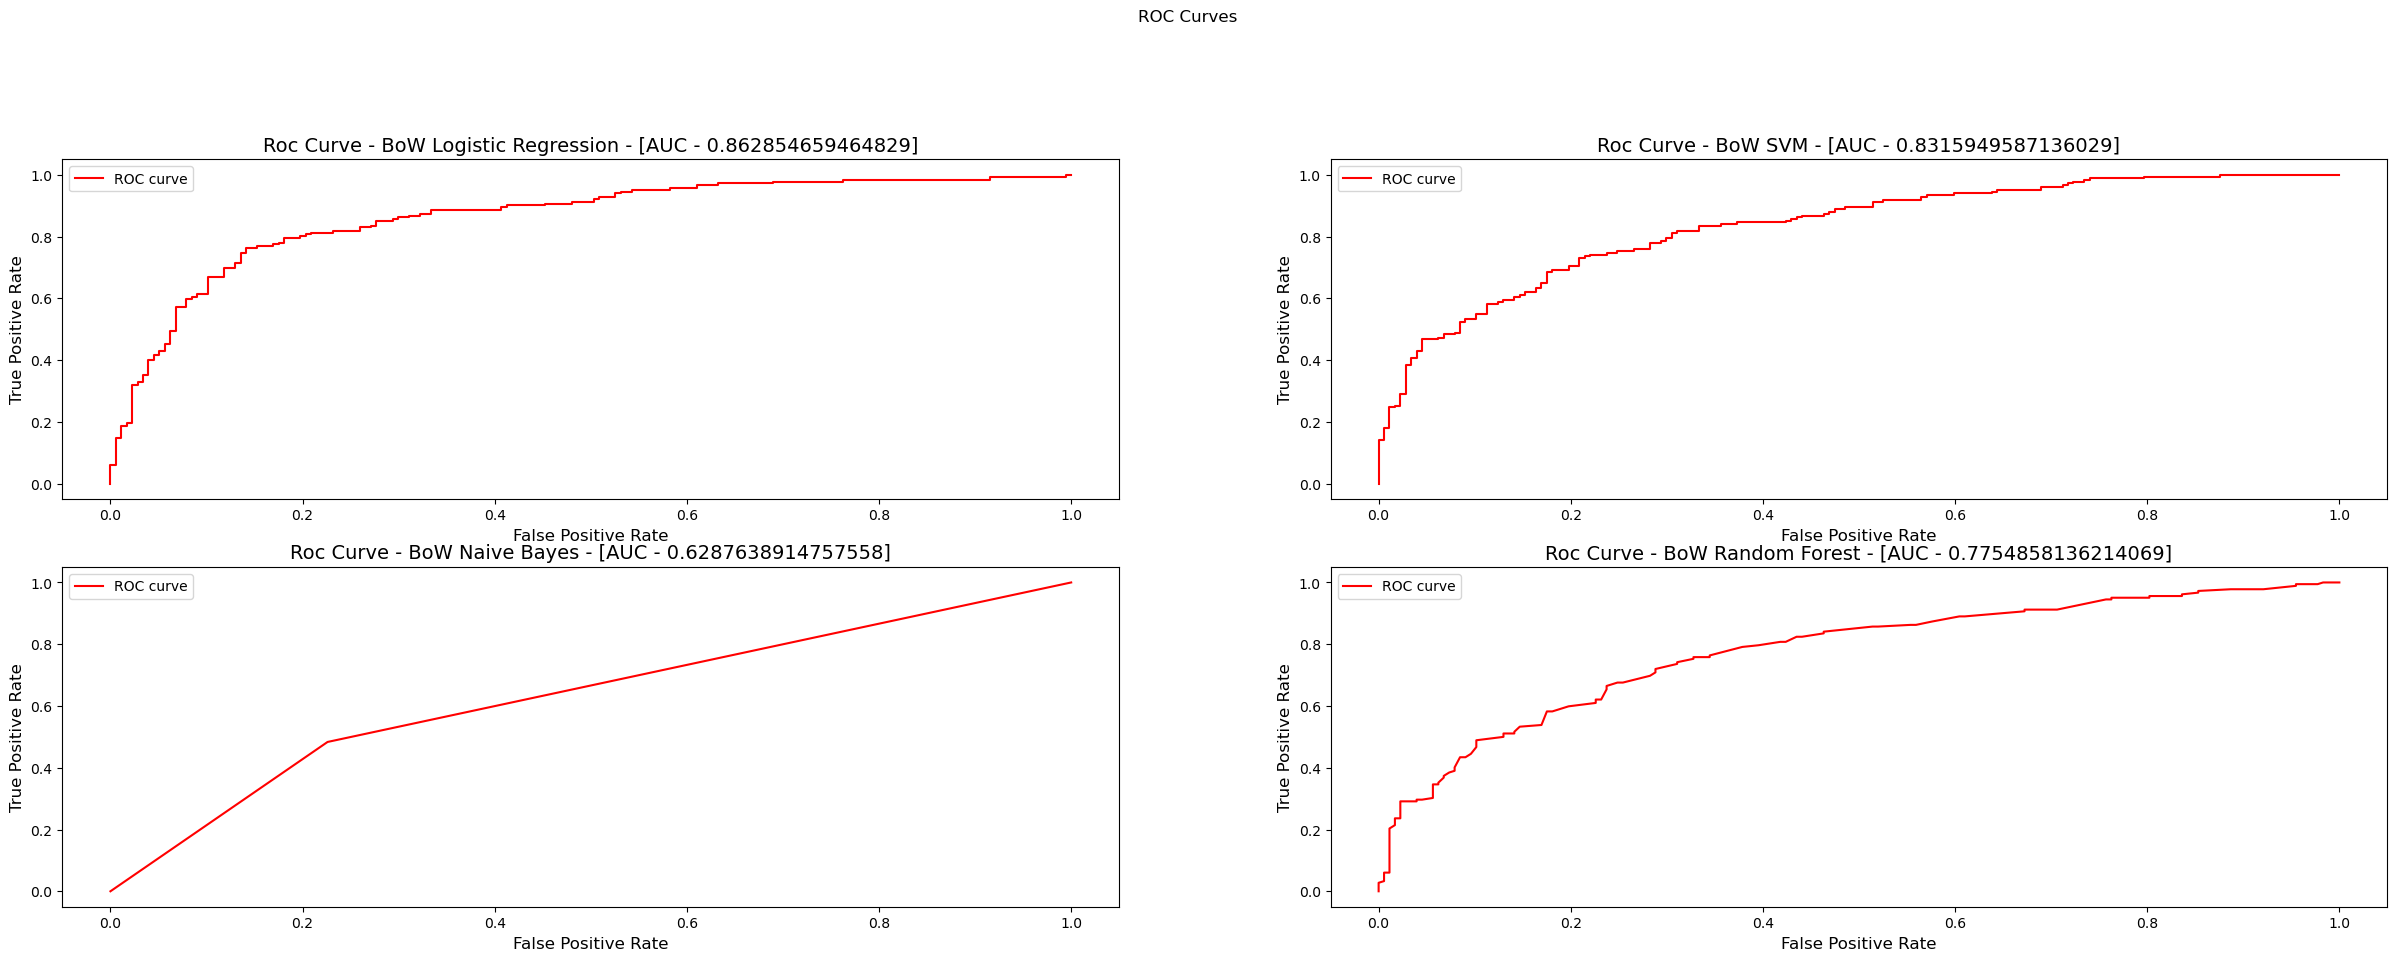

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix, roc_curve, auc
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

# Bag of Words
bag_of_words = CountVectorizer()
x = bag_of_words.fit_transform(df['clean_text'])
x = StandardScaler(with_mean=False).fit_transform(x)
y = df['Sentiment'].values

X_train = bag_of_words.fit_transform(train_df['clean_text'])
Y_train = train_df['Sentiment']
X_test = bag_of_words.transform(df['clean_text'])
Y_test = df['Sentiment']

lr = LogisticRegression(max_iter=sample_size)
lr.fit(X_train, Y_train)
lr_predicted = lr.predict(X_test)
lr_pred_proba = lr.predict_proba(X_test)
print('Bag of Words - Logistic Regression\n', classification_report(Y_test, lr_predicted))

svm = SVC(probability=True, max_iter=sample_size)
svm.fit(X_train, Y_train)
svm_predicted = svm.predict(X_test)
svm_pred_proba = svm.predict_proba(X_test)
print('Bag of Words - SVM\n', classification_report(Y_test, svm_predicted))

bayes = GaussianNB()
bayes.fit(X_train.toarray(), Y_train)
bayes_predicted = bayes.predict(X_test.toarray())
bayes_pred_proba = bayes.predict_proba(X_test.toarray())
print('Bag of Words - Bayes\n', classification_report(Y_test, bayes_predicted))

rfc = RandomForestClassifier()
rfc.fit(X_train, Y_train)
rfc_predicted = rfc.predict(X_test)
rfc_pred_proba = rfc.predict_proba(X_test)
print('Bag of Words - Random Forest\n', classification_report(Y_test, rfc_predicted))

models = ['Logistic Regression', 'SVM', 'Naive Bayes', 'Random Forest']
predictions = [lr_predicted, svm_predicted, bayes_predicted, rfc_predicted]
pred_probabilities = [lr_pred_proba, svm_pred_proba, bayes_pred_proba, rfc_pred_proba]


for model, prediction in zip(models, predictions):
    disp = ConfusionMatrixDisplay(confusion_matrix(Y_test.ravel(), prediction))
    disp.plot(
        include_values=True,
        cmap='gray',
        colorbar=False
    )
    disp.ax_.set_title(f"BoW {model} Confusion Matrix")

plt.figure(figsize=(30, 15))
plt.suptitle("ROC Curves")
plot_index = 1

for model, prediction, pred_proba in zip(models, predictions, pred_probabilities):
    fpr, tpr, thresholds = roc_curve(Y_test, pred_proba[:, 1])
    auc_score = auc(fpr, tpr)
    plt.subplot(3, 2, plot_index)
    plt.plot(fpr, tpr, 'r', label='ROC curve')
    # pyplot.figure(figsize=(5, 5))
    plt.title(f'Roc Curve - BoW {model} - [AUC - {auc_score}]', fontsize=14)
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.legend()
    plot_index += 1
plt.show()

TF-IDF - Logistic Regression
               precision    recall  f1-score   support

           0       0.58      0.98      0.73       177
           1       0.95      0.31      0.46       182

    accuracy                           0.64       359
   macro avg       0.76      0.65      0.60       359
weighted avg       0.77      0.64      0.60       359

TF-IDF - SVM
               precision    recall  f1-score   support

           0       0.55      0.99      0.71       177
           1       0.95      0.23      0.36       182

    accuracy                           0.60       359
   macro avg       0.75      0.61      0.54       359
weighted avg       0.76      0.60      0.53       359

TF-IDF - Bayes
               precision    recall  f1-score   support

           0       0.59      0.78      0.67       177
           1       0.69      0.47      0.56       182

    accuracy                           0.62       359
   macro avg       0.64      0.63      0.62       359
weighted avg  

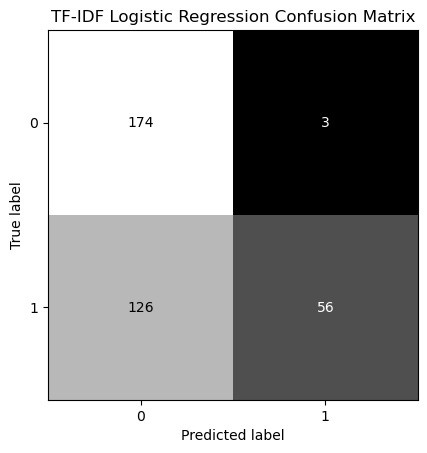

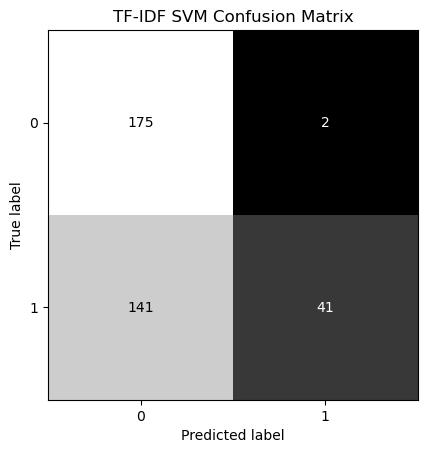

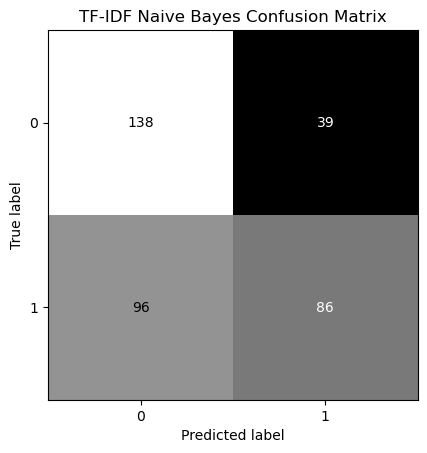

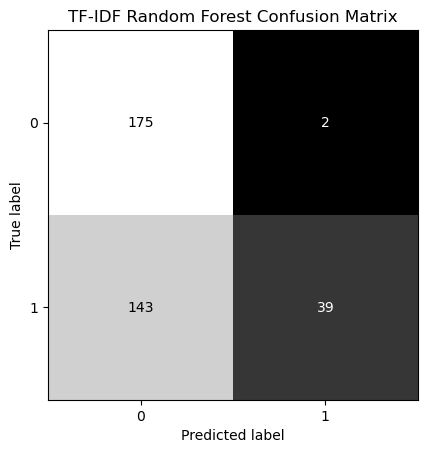

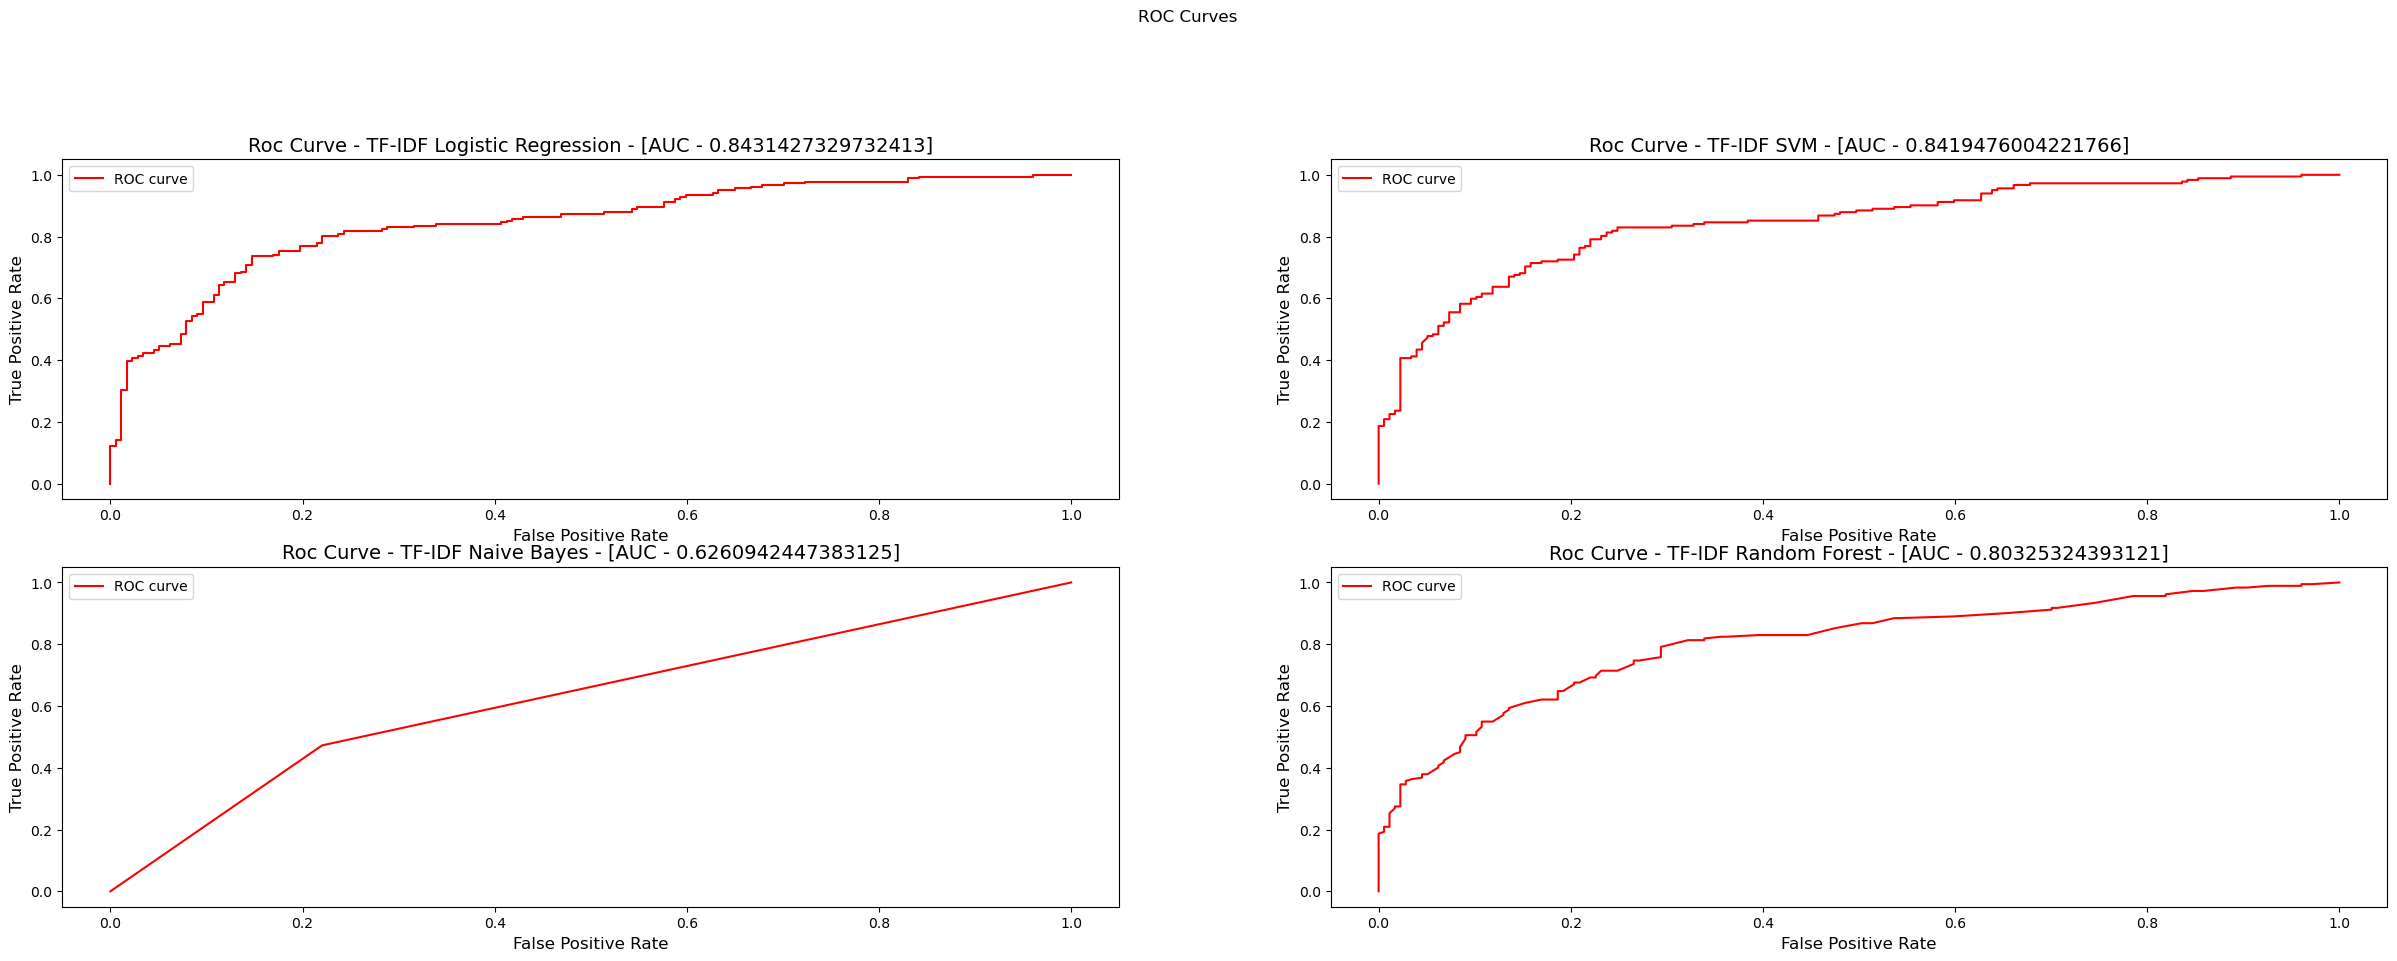

In [4]:
# TF-IDF
tfidf = TfidfVectorizer()
x = tfidf.fit_transform(df['clean_text'])
x = StandardScaler(with_mean=False).fit_transform(x)
y = df['Sentiment'].values

X_train = tfidf.fit_transform(train_df['clean_text'])
Y_train = train_df['Sentiment']
X_test = tfidf.transform(df['clean_text'])
Y_test = df['Sentiment']

lr = LogisticRegression(max_iter=sample_size)
lr.fit(X_train, Y_train)
lr_predicted = lr.predict(X_test)
lr_pred_proba = lr.predict_proba(X_test)
print('TF-IDF - Logistic Regression\n', classification_report(Y_test, lr_predicted))

svm = SVC(probability=True, max_iter=sample_size)
svm.fit(X_train, Y_train)
svm_predicted = svm.predict(X_test)
svm_pred_proba = svm.predict_proba(X_test)
print('TF-IDF - SVM\n', classification_report(Y_test, svm_predicted))

bayes = GaussianNB()
bayes.fit(X_train.toarray(), Y_train)
bayes_predicted = bayes.predict(X_test.toarray())
bayes_pred_proba = bayes.predict_proba(X_test.toarray())
print('TF-IDF - Bayes\n', classification_report(Y_test, bayes_predicted))

rfc = RandomForestClassifier()
rfc.fit(X_train, Y_train)
rfc_predicted = rfc.predict(X_test)
rfc_pred_proba = rfc.predict_proba(X_test)
print('TF-IDF - Random Forest\n', classification_report(Y_test, rfc_predicted))

models = ['Logistic Regression', 'SVM', 'Naive Bayes', 'Random Forest']
predictions = [lr_predicted, svm_predicted, bayes_predicted, rfc_predicted]
pred_probabilities = [lr_pred_proba, svm_pred_proba, bayes_pred_proba, rfc_pred_proba]


for model, prediction in zip(models, predictions):
    disp = ConfusionMatrixDisplay(confusion_matrix(Y_test.ravel(), prediction))
    disp.plot(
        include_values=True,
        cmap='gray',
        colorbar=False
    )
    disp.ax_.set_title(f"TF-IDF {model} Confusion Matrix")

plt.figure(figsize=(30, 15))
plt.suptitle("ROC Curves")
plot_index = 1

for model, prediction, pred_proba in zip(models, predictions, pred_probabilities):
    fpr, tpr, thresholds = roc_curve(Y_test, pred_proba[:, 1])
    auc_score = auc(fpr, tpr)
    plt.subplot(3, 2, plot_index)
    plt.plot(fpr, tpr, 'r', label='ROC curve')
    # pyplot.figure(figsize=(5, 5))
    plt.title(f'Roc Curve - TF-IDF {model} - [AUC - {auc_score}]', fontsize=14)
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.legend()
    plot_index += 1
plt.show()